In [3]:
pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 11.3 MB/s eta 0:00:00


In [7]:
pip install qiskit_ibm_runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 32.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.4/130.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 14.5 MB/s eta 0:00:00
  Created wheel for ibm-platform-services: filename=ibm_platform_services-0.54.2-py3-none-any.whl size=339073 sha256=46867767761cfa33aa4a37abdf6f2a5add6e7b8b13c5ec3fd3a17454bb8ea6f9
  Stored in directory: /root/.cache/pip/wheels/21/c7/86/2c37445d104371878f9366797839da74c921791c0063ccb6b5
  Created wheel for ibm-cloud-sdk

Running QAOA with p = 10
Final QAOA Circuit for p = 10:
     ┌───┐ ┌────────────┐┌─────────────┐ ┌────────────┐             »
q_0: ┤ H ├─┤ Rz(1.4639) ├┤ Rz(-1.4639) ├─┤ Rz(1.4639) ├─■───────────»
     ├───┤┌┴────────────┤└┬────────────┤ ├────────────┤ │ZZ(1.4639) »
q_1: ┤ H ├┤ Rz(-1.4639) ├─┤ Rz(1.4639) ├─┤ Rz(1.4639) ├─■───────────»
     ├───┤└┬────────────┤┌┴────────────┤┌┴────────────┤             »
q_2: ┤ H ├─┤ Rz(1.4639) ├┤ Rz(-1.4639) ├┤ Rz(-1.4639) ├─────────────»
     └───┘ └────────────┘└─────────────┘└─────────────┘             »
c: 3/═══════════════════════════════════════════════════════════════»
                                                                    »
«                                                                      »
«q_0: ─■─────────────────────────■────────────■────────────────────────»
«      │                         │ZZ(1.4639)  │                        »
«q_1: ─┼────────────■────────────■────────────┼────────────■───────────»
«      │ZZ(1.4639)  │Z

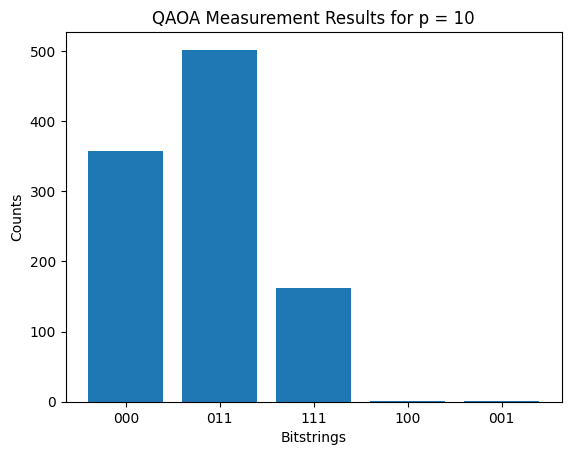

In [11]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import RZZGate
from scipy.optimize import minimize
from qiskit.providers.basic_provider import BasicSimulator
import matplotlib.pyplot as plt
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

def rzzz_gate(qc, q0, q1, q2, gamma):
    """Apply RZZZ gate using 4 CNOTs and an RZ gate."""
    qc.cx(q0, q1)
    qc.cx(q1, q2)
    qc.rz(2 * gamma, q2)
    qc.cx(q1, q2)
    qc.cx(q0, q1)

def create_qaoa_circuit(parameters, clauses, p):
    num_qubits = max(max(abs(lit[0]) for lit in clause) for clause in clauses)
    qr = QuantumRegister(num_qubits, 'q')
    cr = ClassicalRegister(num_qubits, 'c')
    qc = QuantumCircuit(qr, cr)

    # Initial state preparation
    for qubit in qr:
        qc.h(qubit)

    for i in range(p):
        beta, gamma = parameters[2*i], parameters[2*i+1]

        # Problem Hamiltonian
        for clause in clauses:
            for lit in clause:
                var, is_negated = lit
                angle = -gamma if is_negated else gamma
                qc.rz(angle, qr[abs(var)-1])

        # Apply RZZ gates for each pair in the clause
        for clause in clauses:
            vars = [abs(lit[0]) - 1 for lit in clause]
            qc.append(RZZGate(gamma), [vars[0], vars[1]])
            qc.append(RZZGate(gamma), [vars[0], vars[2]])
            qc.append(RZZGate(gamma), [vars[1], vars[2]])

        # Apply RZZZ gate for each clause
        for clause in clauses:
            vars = [abs(lit[0]) - 1 for lit in clause]
            rzzz_gate(qc, vars[0], vars[1], vars[2], gamma)

        # Mixing Hamiltonian
        for qubit in qr:
            qc.rx(2 * beta, qubit)

    qc.measure(qr, cr)

    return qc

def compute_expectation(counts, clauses):
    expectation = 0
    total_counts = sum(counts.values())

    for bitstring, count in counts.items():
        x = [int(bit) for bit in bitstring[::-1]]  # Reverse bitstring to match qubit order
        clause_value = 0
        for clause in clauses:
            clause_value += (x[abs(clause[0][0])-1] if not clause[0][1] else not x[abs(clause[0][0])-1]) or \
                            (x[abs(clause[1][0])-1] if not clause[1][1] else not x[abs(clause[1][0])-1]) or \
                            (x[abs(clause[2][0])-1] if not clause[2][1] else not x[abs(clause[2][0])-1])
        expectation += clause_value * count / total_counts

    return expectation

def objective_function(parameters, clauses, p):
    qc = create_qaoa_circuit(parameters, clauses, p)
    backend = FakeManilaV2()
    tqc = transpile(qc, backend)
    counts = backend.run(tqc).result().get_counts()

    return -compute_expectation(counts, clauses)  # Negative for minimization

# Example clauses for MAX-3SAT
clauses = [
    ((1, False), (2, True), (3, False)),
    ((1, True), (2, False), (3, True)),
    ((1, False), (2, False), (3, True))
]

# Experiment with different values of p
for p in range(10, 11):  # Experiment with p = 1, 2, 3
    print(f"Running QAOA with p = {p}")
    initial_params = np.random.rand(2 * p)
    result = minimize(objective_function, initial_params, args=(clauses, p), method='COBYLA', options={'maxiter': 100})

    optimal_params = result.x
    optimal_value = -result.fun  # Negate back for maximization


    # Create and display the final circuit
    final_circuit = create_qaoa_circuit(optimal_params, clauses, p)
    print(f"Final QAOA Circuit for p = {p}:")
    print(final_circuit)

    # Run the final circuit to get the measurement results
    backend = FakeManilaV2()
    tqc = transpile(final_circuit, backend)
    counts = backend.run(tqc).result().get_counts()
    print(counts)

    # Identify the bitstring with the highest count
    optimal_bitstring = max(counts, key=counts.get)
    optimal_bits = [int(bit) for bit in optimal_bitstring[::-1]]  # Reverse bitstring to match qubit order

    print(f"Optimal bitstring for p = {p}: {optimal_bitstring}")

    # Plot the counts as a bar graph
    bitstrings = list(counts.keys())
    counts_values = list(counts.values())

    plt.bar(bitstrings, counts_values)
    plt.xlabel('Bitstrings')
    plt.ylabel('Counts')
    plt.title(f'QAOA Measurement Results for p = {p}')
    plt.show()